# Elo Merchant

## Introduction
This notebook represents Sean Ng's submission to elo merchant. 

I got some feature engineering ideas from:

https://www.kaggle.com/denzo123/a-closer-look-at-date-variables


## Helper functions to manage memory

In [914]:
import gc
gc.collect()

156124

In [915]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [916]:
#To reset all variables
def remove_var(*varnames):
    """
    varnames are what you want to keep
    """
    globals_ = globals()
    to_save = {v: globals_[v] for v in globals_ if v not in varnames }
    to_save['my_reset'] = my_reset  # lets keep this function by default
    del globals_
    get_ipython().magic("reset")
    globals().update(to_save)

In [917]:
def find_variables():
    import sys

    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [918]:
## Importing data

In [919]:
#Declaring imports
import csv
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgd


In [920]:
EXPLORE = False

In [921]:
#Files
train_data_path = '../input/train.csv'
test_data_path = '../input/test.csv'
history_path = '../input/historical_transactions.csv'
merchant_path = '../input/merchants.csv'
new_transactions_path = '../input/new_merchant_transactions.csv'


In [922]:
train_df = reduce_mem_usage(pd.read_csv(train_data_path, parse_dates=["first_active_month"]))
test_df = reduce_mem_usage(pd.read_csv(test_data_path, parse_dates=["first_active_month"]))


Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [ ]:
merchants = pd.read_csv(merchant_path)

In [ ]:
all_transactions = reduce_mem_usage(
    pd.read_csv(new_transactions_path, parse_dates=["purchase_date"])
    .append(
        pd.read_csv(history_path, parse_dates=["purchase_date"]),
        ignore_index=True
    )
)

In [ ]:
n_new_transactions = pd.read_csv(new_transactions_path, parse_dates=["purchase_date"]).shape[0]

## Simple exploration

In [ ]:
all_data.describe()

In [ ]:
if EXPLORE:
    all_transactions.describe()

In [ ]:
print("All data shape:" + str(all_data.shape))
print("-----------------------------------------------------")
print("Train data shape:" + str(train_df.shape))
print("Test data shape:" + str(test_df.shape))
print("=====================================================")
print("All transactions data shape:" + str(all_transactions.shape))
print("-----------------------------------------------------")
print("Old transactions data shape:" + str(history_df.shape))
print("New transactions data shape:" + str(new_transactions_df.shape))

In [ ]:
def get_df_name(df):
    for x in globals():
        if globals()[x] is df:
            return x

In [ ]:
#Finding number of null values
def count_nulls(df_list):
    result = {}
    for df in df_list:
        vals = {}
        for key in df.keys():
            count = df[key].isnull().sum()
            if count > 0:
                vals[key] = count
        name = get_df_name(df)
        result[name] = vals
    return pd.DataFrame.from_dict(result, dtype=int)
count_nulls([all_data, all_transactions, merchants])


# Handling Nulls

1. Viewing the distribution of non-null values

In [ ]:
#putting each col into a bucket
def classify_categories(df, cols):
    discrete = []
    continuous = []
    for col in cols:
        
        length = len(df[col].unique())
        if length <= 25 :
            discrete.append(col)
        else:
            continuous.append(col)
    return discrete, continuous


In [ ]:
def plot_na(df, cols):
    discrete, continuous = classify_categories(df, cols)
    all_count = len(continuous) + len(discrete)
    #Distributions of continuous dVata
    fig, axes = plt.subplots(nrows=all_count, ncols=1, figsize=(3,5*all_count))
    if all_count == 1:
        axes = [axes]
    for i, col_name in enumerate(discrete):
        df[col_name].value_counts().plot(kind='bar', ax=axes[i], title = col_name)
    for i, col_name in enumerate(continuous):
        df[col_name].plot(kind='density', ax=axes[i+len(discrete)], title = col_name)
    


In [ ]:
if EXPLORE:
    plot_na(all_transactions, ["category_2", "category_3"])

In [ ]:
if EXPLORE:
    plot_na(merchants, ['avg_sales_lag12','avg_sales_lag3','avg_sales_lag6','category_2'])

In [ ]:
if EXPLORE:
    #Plot date to get a rough idea
    all_data.set_index(['first_active_month']).groupby('first_active_month').card_id.count().plot()

In [ ]:
if EXPLORE:
    merchants.avg_sales_lag3[merchants.avg_sales_lag3!=np.nan].sort_values(ascending=False)[500:].plot()

In [ ]:
n_train

# Looking at distribution of target value

In [ ]:
from scipy import stats
from scipy.stats import norm, skew
#Check the new distribution 
sns.distplot(train_df['target'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['target'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('target distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['target'], plot=plt)
plt.show()

In [ ]:
#Remove outlier
#train_df = train_df[train_df['target']>-30]
all_data = train_df.append(test_df, ignore_index=True)
n_train = train_df.shape[0]


# Feature Engineering

## Converting date to corresponding date difference

In [ ]:
all_data["time_difference"] = (datetime.today() - all_data["first_active_month"]).dt.days

In [ ]:
all_transactions["time_diff_transaction"] = (datetime.today() - all_transactions["purchase_date"]).dt.days

In [ ]:
all_transactions["hour"] = all_transactions["purchase_date"].dt.hour

In [ ]:
all_transactions["month_diff"] = all_transactions.time_diff_transaction//30

In [ ]:
all_transactions["month_diff"] += all_transactions["month_lag"]

## Making the day of week relevant

In [ ]:
all_transactions["day_of_week"] = all_transactions["purchase_date"].dt.weekday


In [ ]:
all_transactions["weekend"] = (all_transactions["day_of_week"]>=5).astype(int)

## Seperating data by flag because apparently they have significant difference

In [ ]:
flag = all_transactions["authorized_flag"].copy()

## LabelEncode/ Hot Encode the necessary values


In [ ]:
from sklearn.preprocessing import LabelEncoder
def LabelEncodeCols(df, cols):
    new_df = df.copy()
    for col in cols:
        lbl = LabelEncoder()
        new_df[col] = lbl.fit_transform(new_df[col])
    return new_df



In [ ]:
all_transactions = LabelEncodeCols(all_transactions, ["authorized_flag", "category_1"])

In [ ]:
all_transactions = pd.get_dummies(all_transactions, columns=["category_2", "category_3", "day_of_week"])

In [ ]:
all_transactions_flagged.shape

In [ ]:
all_transactions.shape

# Aggregate values 

In [ ]:
def aggregate(history):
    
    agg = {
        "authorized_flag":["mean", "var"],
        "category_1":["mean", "var", "sum"],
        "category_2_1.0":["mean"], 
        "category_2_2.0":["mean"],
        "category_2_3.0":["mean"],
        "category_2_4.0":["mean"],
        "category_2_5.0":["mean"],
        "category_3_A":["mean"],
        "category_3_B":["mean"],
        "category_3_C":["mean"],
        "city_id":['nunique'],
        "month_lag":[np.ptp, "mean"],
        "installments":["max", "mean", "var"],
        "weekend":["sum", "mean"],
        "merchant_id":['nunique'],
        "state_id":['nunique'],
        "subsector_id":["nunique"],
        "purchase_amount":["mean", "std", "min", "max"],
        "day_of_week_0":["mean"],
        "day_of_week_1":["mean"],
        "day_of_week_2":["mean"],
        "day_of_week_3":["mean"],
        "day_of_week_4":["mean"],
        "day_of_week_5":["mean"],
        "day_of_week_6":["mean"],
        "card_id":["size"],
        "time_diff_transaction":["mean", "var", "min", "max"],
        "hour":["mean", "var", "min", "max"],
        "month_diff":["mean", "var", "min", "max"],
    }
    
    new_df = history.groupby("card_id").agg(agg)
    #Replace columns
    new_df.columns = [' '.join(col).strip() for col in new_df.columns.values]
    return new_df
    

In [ ]:
all_transactions.head()

In [ ]:
aggregate_unflagged_transactions = aggregate(all_transactions[flag=='Y'])
aggregate_flagged_transactions = aggregate(all_transactions[flag=='N'])
aggregate_new_transactions = aggregate(all_transactions[:n_new_transactions])
aggregate_old_transactions = aggregate(all_transactions[n_new_transactions:])

In [ ]:
aggregate_all_transactions = aggregate(all_transactions)

In [ ]:
old_all_data = all_data.copy()

In [ ]:
all_data = old_all_data.copy()

In [ ]:
aggregate_flagged_transactions.columns = ["flag_" + x for x in aggregate_flagged_transactions.keys()]

In [ ]:
aggregate_unflagged_transactions.columns = ["unflagged_" + x for x in aggregate_unflagged_transactions.keys()]

In [ ]:

aggregate_new_transactions.columns = ["new_" + x for x in aggregate_new_transactions.keys()]

In [ ]:

aggregate_old_transactions.columns = ["old_" + x for x in aggregate_old_transactions.keys()]

In [ ]:
print(all_data.columns.values)

In [ ]:
all_data = pd.merge(all_data, aggregate_unflagged_transactions, on='card_id', how='left')

In [ ]:
all_data = pd.merge(all_data, aggregate_flagged_transactions, on='card_id', how='left')


In [ ]:
all_data = pd.merge(all_data, aggregate_new_transactions, on='card_id', how='left')


In [ ]:
all_data = pd.merge(all_data, aggregate_old_transactions, on='card_id', how='left')


In [ ]:
all_data = pd.merge(all_data, aggregate_all_transactions, on='card_id', how='left')

In [ ]:
#Consider adding other columns. i.e. grouping the values across time (!!!!!)

In [ ]:
#tuning hyperparameters

In [ ]:
#Features that others added
#Handling month_lag?

1. Month difference between today and purchase date (might be more significant than just date(?). I need to be able to convert to something significant anyway
2. Aggregation based statistics


In [ ]:
months = all_data['first_active_month']
del all_data['first_active_month']

In [ ]:
all_data.fillna(0, inplace=True)

# Aggregate by month

In [907]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

In [908]:
agg_history = aggreagate_per_month(all_transactions)

NameError: name 'aggreagate_per_month' is not defined

# Training Phase

Index(['card_id', 'feature_1', 'feature_2', 'feature_3', 'target',
       'time_difference', 'unflagged_authorized_flag mean',
       'unflagged_authorized_flag var', 'unflagged_category_1 mean',
       'unflagged_category_1 var',
       ...
       'time_diff_transaction min', 'time_diff_transaction max', 'hour mean',
       'hour var', 'hour min', 'hour max', 'month_diff mean', 'month_diff var',
       'month_diff min', 'month_diff max'],
      dtype='object', length=246)

In [897]:
all_data = reduce_mem_usage(all_data)

Mem. usage decreased to 156.34 Mb (72.3% reduction)


In [898]:
if "target" in all_data.keys():
    target = all_data["target"][:n_train]
to_be_deleted = ["target", "card_id"]
for col in to_be_deleted:
    if col in all_data.keys():
        del all_data[col]
train = all_data[:n_train]
test = all_data[n_train:]

In [834]:
# Selecting the right features
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [905]:
import time
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
def run_lgbm_cv():
    categorical_feats = ["feature_2", "feature_3"]
    folds = KFold(n_splits = 5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()
    features = all_data.keys()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )

        num_round = 10000
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

    print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
    return feature_importance_df, predictions

In [906]:
feature_importance_df, predictions = run_lgbm_cv()

fold n°0


/anaconda/envs/tensorflow/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda/envs/tensorflow/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.6299	valid_1's rmse: 1.64284
[200]	training's rmse: 1.58768	valid_1's rmse: 1.60862
[300]	training's rmse: 1.56354	valid_1's rmse: 1.59175
[400]	training's rmse: 1.54751	valid_1's rmse: 1.58261
[500]	training's rmse: 1.5354	valid_1's rmse: 1.57708
[600]	training's rmse: 1.5256	valid_1's rmse: 1.5733
[700]	training's rmse: 1.51741	valid_1's rmse: 1.57073
[800]	training's rmse: 1.51017	valid_1's rmse: 1.56885
[900]	training's rmse: 1.50378	valid_1's rmse: 1.56759
[1000]	training's rmse: 1.4982	valid_1's rmse: 1.56669
[1100]	training's rmse: 1.493	valid_1's rmse: 1.5659
[1200]	training's rmse: 1.48809	valid_1's rmse: 1.56533
[1300]	training's rmse: 1.48358	valid_1's rmse: 1.56493
[1400]	training's rmse: 1.4793	valid_1's rmse: 1.5646
[1500]	training's rmse: 1.47541	valid_1's rmse: 1.56439
[1600]	training's rmse: 1.47157	valid_1's rmse: 1.56422
[1700]	training's rmse: 1.46779	valid_1's rmse: 1.56414
[180

In [909]:

feature_importances = feature_importance_df.groupby("feature").mean().sort_values(by="importance", ascending=False)

In [910]:

feature_importances = feature_importances.reset_index()


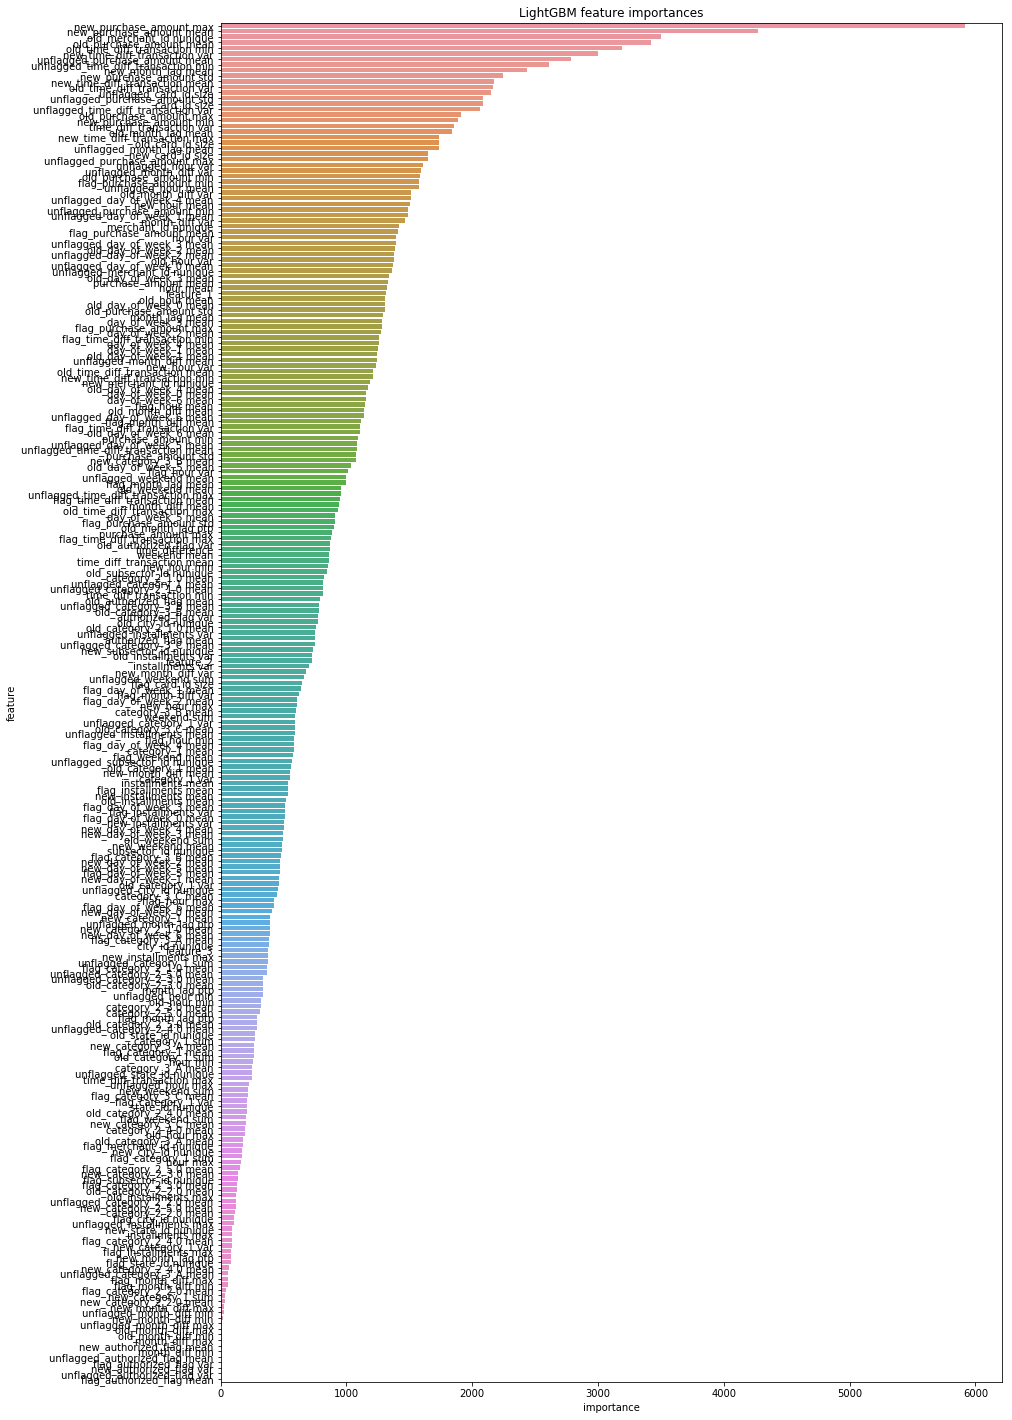

In [912]:
EXPLORE = True
if EXPLORE:
    plt.figure(figsize=(14,25))
    
    plt.title('LightGBM feature importances')
    sns.barplot(x="importance", y="feature", data=feature_importances)

In [913]:
sub_df = pd.DataFrame({"card_id":test_df.card_id.values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

In [ ]:
if EXPLORE:
    corrmat = all_data.corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corrmat, vmax=0.9, square=True)

In [505]:
n_folds=5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, target, scoring="neg_mean_squared_error", cv = kf, verbose=1))
    return(rmse)

In [590]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb


In [899]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.001, random_state=1, tol=0.3))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.5, l1_ratio=.9, random_state=3))
ridge = make_pipeline(RobustScaler(), Ridge(alpha=10))

In [900]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv


Lasso score: 1.7702 (0.3049)



/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.2min finished


In [901]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

ElasticNet score: 2.2766 (1.2159)



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


In [902]:
score = rmsle_cv(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Ridge score: 1.6861 (0.1240)



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   39.8s finished


#Doesn't seem to work
KRR =  KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [778]:
GBoost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


KeyboardInterrupt: 

In [903]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             n_estimators=100,
                             random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 1.5898 (0.0112)



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.4min finished


In [904]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

KeyboardInterrupt: 